# Meta Analysis
![](./images/Module5/Module5.jpg)


Meta pathway analysis using multiple omics data is a rapidly emerging field in bioinformatics and systems biology that allows for the integration of diverse omics data from genomics, transcriptomics, proteomics, metabolomics, and other molecular biology disciplines. By integrating multiple omics data, meta pathway analysis aims to provide a comprehensive understanding of the cellular functions and molecular mechanisms underlying biological processes in a given organism. This approach offers a powerful means to investigate the complex interplay between genes, proteins, and metabolites in different biological contexts, such as disease states or environmental conditions. Moreover, meta pathway analysis can identify key regulatory pathways and molecular signatures that are critical for the development of targeted therapeutics and precision medicine. Overall, the integration of multiple omics data through meta pathway analysis has the potential to reveal new insights into the underlying biology of complex diseases and to guide the development of personalized treatments. In this submodule, we will demonstrate the power of meta-analysis to find the significant pathways for Alzheimer and Parkinson diseases.

## Learning Objectives:
1. Downloading processed data
2. Performing enrichment analysis using FGSEA and plotting results
3. Performing meta-analysis and plotting results

In [1]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule5.html" width=100% height=250></iframe>')

## Loading Datasets
In this submodule 5, we will use datasets available from the Gene Expression Omnibus (GEO) repository. The datasets analyzed for Alzheimer disease is available under accession number `GSE5281`. This dataset contains genes that are preferentially expressed during the course of Alzheimer’s disease (AD) collected from 5 different brain regions: 1) entorhinal cortex (EC) 2) hippocampus (HIP) 3) medial temporal gyrus (MTG) 4) posterior cingulate 5) superior frontal gyrus and 6) primary visual cortex. In this submodule, we will perform analysis using data generated from EC, HIP, and MTG.

The datasets analyzed for Parkinson disease are available under accession numbers `GSE99039` and `GSE20292`. The first dataset contains 558 blood-based gene signature characterizing Idiopathic Parkinson's disease while the second dataset has 29 transcriptional analyses of whole substantia nigra in Parkinson's disease. Users can follow the instructions provided in submodules 1 and 2 to download and perform genes ID mapping. In this submodule, we will load the preprocessed data stored in the NIGMS Google Cloud Storage bucket to perform analysis. The code to load all datasets is presented as follows:

In [2]:
# A vector to store all data IDs
data.IDs <- c("GSE5281-EC", "GSE5281-HIP", "GSE5281-MTG", "GSE99039", "GSE20292")
# A loop to read data information and store into a list
allData <- lapply(data.IDs, function(id){
    f <- paste0( "https://storage.googleapis.com/nigms-sandbox/nosi-unr/", id, ".rds")
    if (!file.exists(f)) return(readRDS(url(f), "rb"))
    return(NULL)
})

## Installing Required Libraries
In this submodule, we will install several libraries to perform enrichment analysis, meta-analysis and visualization. We will install package `fgsea` to perform enrichment analysis. For visualization purposes, we will use `ggpubr` and `cowplot`. `ggpubr` provides a range of functions that enable users to create publication-ready plots, including barplots, boxplots, scatterplots, histograms, and heatmaps. `cowplot` provides the ability to create custom layouts for complex multi-panel figures. The package includes functions for arranging plots in a grid, as well as for adding margins, padding, and labels. The package also includes features for aligning plots, adjusting font sizes and colors, and exporting plots to different file formats. To perform meta-analysis, we will use the `meta` R package which provides functions for conducting fixed-effect and random-effects meta-analyses, as well as for conducting sensitivity analyses, subgroup analyses, and meta-regression analyses. The package also provides tools for assessing the heterogeneity of the studies included in the analysis and for creating forest plots to visualize the results. Lastly, packages include `stringr` and `matrixStats` provide utility functions to manipulate input matrices. The package `fgsea` can be downloaded from Bioconductor while other packages can be installed from CRAN. The code to install all packages is presented below:

In [3]:
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        suppressWarnings(install.packages("BiocManager"))
        suppressWarnings(if (!require("fgsea")) BiocManager::install("fgsea", update = F))
    }
})

In [4]:
suppressMessages({
    # Installing all packages
    suppressWarnings(if (!require("stringr")) install.packages("stringr"))
    suppressWarnings(if (!require("meta")) install.packages("meta"))
    suppressWarnings(if (!require("matrixStats")) install.packages("matrixStats"))
    suppressWarnings(if (!require("cowplot")) install.packages("cowplot"))
    suppressWarnings(if (!require("ggpubr")) install.packages("ggpubr"))
    suppressWarnings(if (!require("dplyr")) install.packages("dplyr"))
    suppressWarnings(if (!require("tidyr")) install.packages("tidyr"))
    suppressWarnings(if (!require("ggvenn")) install.packages("ggvenn"))
    suppressWarnings(if (!require("ggnewscale")) install.packages("ggnewscale"))
                     
    # Loading all packages
    suppressPackageStartupMessages({library(fgsea)})
    suppressPackageStartupMessages({library(stringr)})
    suppressPackageStartupMessages({library(meta)})
    suppressPackageStartupMessages({library(matrixStats)})
    suppressPackageStartupMessages({library(cowplot)})
    suppressPackageStartupMessages({library(ggpubr)})
    suppressPackageStartupMessages({library(dplyr)})
    suppressPackageStartupMessages({library(tidyr)})
    suppressPackageStartupMessages({library(ggvenn)})
    suppressPackageStartupMessages({library(ggnewscale)})
                     
})



The downloaded binary packages are in
	/var/folders/lz/5chptxdx2yg5vvszdt29pt400000gn/T//RtmpHUxaqQ/downloaded_packages

The downloaded binary packages are in
	/var/folders/lz/5chptxdx2yg5vvszdt29pt400000gn/T//RtmpHUxaqQ/downloaded_packages


## Utility Function
To perform enrichment analysis we will need a helper function to obtain pathway information from the KEGG database.
The `getKEGGGeneSet` shown below will access to KEGG database and download all the genesets for all the human pathways.
The result will be stored in a list.


In [5]:
#' @description Retrieves gene sets from the KEGG database based on the specified organism code.
#'
#' @param org A character string representing the organism code for the KEGG database.
#' @return A list of gene sets, where each element contains the name and genes of a specific pathway.

getKEGGGeneSet <- function(org) {
    # Get data from the KEGG database and save it to a data frame
    geneLink <- read.table(
        paste0("https://rest.kegg.jp/link/", org, "/pathway"),
        sep = "\t", header = FALSE,
        stringsAsFactors = FALSE
    )
  
    # Name the data columns
    colnames(geneLink) <- c("geneset", "gene")

    # Get genes for each geneset and store the result in a list
    geneLink <- lapply(split(geneLink, geneLink$geneset), function(dat) {
        list(
            name = as.character(dat$geneset[1]),
            genes = as.character(dat$gene)
        )
    })

    # Set names of the list based on the geneset name
    names(geneLink) <- lapply(geneLink, function(gl) gl$name)

    # Extract only the genes for each geneset
    geneLink <- lapply(geneLink, function(gl) gl$genes)

    # Keep only genesets with at least 5 genes
    lengths_list <- lapply(geneLink, length)
    keeps <- names(which(unlist(lengths_list) >= 5))
    geneLink <- geneLink[keeps]

    # Return the final list of genesets
    return(geneLink)
}


## Enrichment Analysis using FGSEA
In this section, we will perform enrichment analysis using the `fgsea` package for all methods.
FGSEA is an extension of the widely used Gene Set Enrichment Analysis (GSEA) method, which computes
an enrichment score for each gene set by comparing the distribution of genes in the set with the
 distribution of all genes. FGSEA, on the other hand, uses a fast algorithm to estimate the p-value
 for each gene set, based on the empirical distribution of the enrichment score obtained by permuting
 the gene labels in the ranked list.

The basic steps in performing FGSEA are as follows:

1. Rank the genes according to a certain metric, such as gene expression or differential expression.
2. Define a set of genes of interest, such as a pathway or a gene ontology term.
3. Compute the enrichment score for each gene set based on the ranks of its member genes in the ranked list.
4. Generate a null distribution of enrichment scores by permuting the gene labels in the ranked list.
5. Compute the p-value for each gene set by comparing its observed enrichment score with the null distribution.
6. Correct for multiple testing, for example, by using the false discovery rate (FDR) or the Bonferroni method.

To run the method `fgsea` we use 1,000 permutations and the signal-to-noise ratio (SNR) is set to the ratio of differences
of mean and standard deviation between control and disease groups.
Now, we need to get the geneset and do parameter settings.

In [6]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule5-1.html" width=100% height=250></iframe>')

In [7]:
# Assign names to all datasets
names(allData) <- data.IDs
# Remove empty dataset
allData <- allData[!sapply(allData, is.null)]
# Get all human geneset
geneSet <- getKEGGGeneSet("hsa")
# Get unique geneset
genes <- unique(unlist(geneSet))
# Parameter to set the number of permutations
perm <- 1000


We can check the number of pathways for human using the following command:

In [8]:
print(paste0("The number of pathways is: ", length(geneSet)))

[1] "The number of pathways is: 352"


We can view the names of the first 10 pathways using the following command:


In [9]:
names(geneSet)[1:10]

[1] "path:hsa00010" "path:hsa00020" "path:hsa00030" "path:hsa00040"
 [5] "path:hsa00051" "path:hsa00052" "path:hsa00053" "path:hsa00061"
 [9] "path:hsa00062" "path:hsa00071"

We can view the name of first 10 genes of the first pathway using the following command:

In [10]:
geneSet[["path:hsa00010"]][1:10]

[1] "hsa:10327"  "hsa:124"    "hsa:125"    "hsa:126"    "hsa:127"   
 [6] "hsa:128"    "hsa:130"    "hsa:130589" "hsa:131"    "hsa:160287"

Now, we can perform enrichment analysis for all datasets using the following script

In [11]:
allEnrichmentResult <- lapply(1:length(allData), function(iteration){
    # Set seed for reproducibility
    set.seed(iteration)
    # Get the data
    data <- allData[[iteration]]
    data <- data[[1]]
    # Get expression matrix
    exprs <- data$expression
    # Get group information (control vs disease)
    group <- data$group
    annotation <- data$annotation
    exprs <- exprs[intersect(genes, rownames(exprs)), ]
    control.samples <- names(group[group == "c"])
    disease.samples <- names(group[group == "d"])
    exprs <- as.matrix(exprs)
    # Calculate signal to noise
    snr <- (rowMeans(exprs[, disease.samples]) -
             rowMeans(exprs[, control.samples])) / (rowSds(exprs[, disease.samples]) +
            rowSds(exprs[, control.samples]))
    # Perform enrichment analysis
    res <- suppressWarnings(fgsea(pathways = geneSet,
                                   stats = snr, nperm = perm))

    res$pvals$sample.size <- ncol(exprs)
    # Store results in a list
    list(
        id = names(allData)[iteration],
        data = data,
        res = res
    )
})
# Assign names using dataset ID to the results
names(allEnrichmentResult) <- names(allData)


We can view the enrichment analysis result for the first dataset using the following command. The result is saved in a data frame in which the first three columns contain pathway names, p-value, and adjusted p-value. The next column has the Enrichment Score calculated by walking down the ranked list of genes, and at each step, adding the running sum of the enrichment score for the gene set. The enrichment score is defined as the difference between the proportion of genes in the gene set that are up-regulated and the proportion of genes in the gene set that are down-regulated, multiplied by the degree of differential expression. The next column has the Normalized Enrichment Score (NES) that takes into account both the enrichment of the gene set and its size, and it is normalized to correct for the multiple hypothesis testing performed in the analysis.

In the next column, the NES score is calculated as the maximum deviation of the enrichment score from the expected null distribution, divided by the standard deviation of the scores of all possible permutations of the gene set labels. nMoreExtreme is a statistical metric to estimate the significance of the enrichment score of a gene set in a ranked list of genes. The "size" column of a gene set is an important factor that can affect the interpretation of the enrichment analysis results. The "leadingEdge" column is a subset of genes within a gene set that contribute most to the enrichment signal of the gene set in a ranked list of genes.

In [12]:
allEnrichmentResult[["GSE5281-EC"]]$res[1:10, ]

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge,pvals
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<int>
path:hsa00010,0.23597679,0.42635409,-0.2425494,-1.1466941,121,65,"hsa:2597 , hsa:226 , hsa:5315 , hsa:92579, hsa:10327, hsa:7167 , hsa:3939 , hsa:2821 , hsa:5211 , hsa:3098 , hsa:5106 , hsa:5213 , hsa:5230 , hsa:8789 , hsa:2023 , hsa:2203 , hsa:2026 , hsa:219 , hsa:230 , hsa:55902, hsa:229 , hsa:2027 , hsa:5232 , hsa:26330, hsa:5236 , hsa:3101 , hsa:131 , hsa:218 , hsa:80201, hsa:124 , hsa:130 , hsa:83440, hsa:5160 , hsa:222",100
path:hsa00020,0.50943396,0.67438778,-0.2534200,-0.9712870,269,29,"hsa:3421, hsa:47 , hsa:1431",100
path:hsa00030,0.09177820,0.21976821,-0.3510829,-1.3561897,47,30,"hsa:2539 , hsa:226 , hsa:25796 , hsa:2821 , hsa:5211 , hsa:5213 , hsa:8277 , hsa:23729 , hsa:8789 , hsa:414328, hsa:2203 , hsa:230 , hsa:229 , hsa:7086",100
path:hsa00040,0.34351145,0.51850710,-0.2978949,-1.0868872,179,25,"hsa:6652 , hsa:27294, hsa:10327, hsa:54576, hsa:54658, hsa:55277, hsa:54578, hsa:54659, hsa:9942 , hsa:54600, hsa:54490, hsa:57016",100
path:hsa00051,0.01976285,0.08805724,-0.4213986,-1.6706887,9,33,"hsa:7264 , hsa:6652 , hsa:226 , hsa:5373 , hsa:7167 , hsa:29925, hsa:5211 , hsa:3098 , hsa:29926, hsa:5213 , hsa:5207 , hsa:5372 , hsa:3795 , hsa:8789 , hsa:55556, hsa:2203 , hsa:230 , hsa:229 , hsa:26007",100
path:hsa00052,0.64694656,0.77721908,-0.2259832,-0.8829938,338,31,"hsa:92579, hsa:5211 , hsa:3098 , hsa:2582 , hsa:2592 , hsa:5213",100
path:hsa00053,0.95539033,0.98910999,-0.1716047,-0.6091810,513,22,"hsa:10327, hsa:54576, hsa:54658, hsa:54578, hsa:54659, hsa:219 , hsa:54600, hsa:54490",100
path:hsa00061,0.53430353,0.69657350,0.2761760,0.9253558,256,17,"hsa:32 , hsa:84869, hsa:2180 , hsa:23305, hsa:51703, hsa:2181 , hsa:23205",100
path:hsa00062,0.07649254,0.19923440,-0.3729676,-1.3882241,40,26,"hsa:9524 , hsa:11332 , hsa:3033 , hsa:401494, hsa:117145, hsa:51495 , hsa:9200 , hsa:51144 , hsa:9374 , hsa:79071 , hsa:51102 , hsa:3030",100


We can select the significant pathways and calculate the statistics of NES scores. The result is stored in a list which contains the name of datasets (IDs), results of enrichment analysis generated from the FGSEA method and statistics of NES score.

In [13]:
# Apply a function to each element in allEnrichmentResult
plots.enrichment.data <- lapply(allEnrichmentResult, function(data){

    # Extract necessary data for plotting
    plot.data <- data$res
    rownames(plot.data) <- plot.data$pathway
    plot.data$dataset <- data$id
    
    # Calculate standardized NES deviation (NES.sd) for better visualization
    plot.data$NES.sd = abs((plot.data$NES - ifelse(plot.data$NES > 0, 1, -1))/qnorm(plot.data$pval))
    
    # Limit the NES.sd values to a maximum of 0.5
    sd <- plot.data$NES.sd
    sd[sd > 0.5] <- 0.5
    
    # Calculate minimum and maximum values for the plot
    plot.data$min <- plot.data$NES - sd*2
    plot.data$max <- plot.data$NES + sd*2
    
    # Clip extreme values to ensure they are within reasonable limits
    plot.data$min[plot.data$min < -2.5] <- -2.5
    plot.data$max[plot.data$max > 2.5] <- 2.5
    
    # Extract ES values for the corresponding gene set
    ES.df <- as.data.frame(data$res$ES)
    rownames(ES.df) <- names(geneSet)
    
    # Return a list containing the dataset id, plotting data, and ES values
    list(
        id = data$id,
        res = plot.data,
        ES = ES.df
    )
})


To view the summary of NES scores for the first ten pathways in the first dataset, we can use the following command:

In [14]:
plots.enrichment.data[["GSE5281-EC"]]$res[1:10, c(1, 11:13)]

pathway,NES.sd,min,max
<chr>,<dbl>,<dbl>,<dbl>
path:hsa00010,0.2039389,-1.55457176,-0.73881634
path:hsa00020,1.2141000,-1.97128697,0.02871303
path:hsa00030,0.2678351,-1.89185985,-0.82051949
path:hsa00040,0.2156553,-1.51819784,-0.65557656
path:hsa00051,0.3257871,-2.32226286,-1.01911451
path:hsa00052,0.3102873,-1.50356850,-0.26241911
path:hsa00053,0.2299571,-1.06909517,-0.14926674
path:hsa00061,0.8670242,-0.07464423,1.92535577
path:hsa00062,0.2716627,-1.93154943,-0.84489872


Next we can use `ggplot` library to visualize the NES scores of each pathway across all datasets.

In [15]:
# We will pick ten pathways for visualization
picked.pathways.names <- names(geneSet)[1:10]

# This is the main script to plot the enrichment score for each pathway.
# The script will generate the plot for each dataset and store in a list
plts <- lapply(plots.enrichment.data, function(data) {
    # Set the title of each plot by the dataset name
    name_plot <- data$id
    # Get the data for plotting
    plot.data <- data$res 
    # Filter the data for the selected pathways
    selected_pathways <- plot.data$pathway %in% picked.pathways.names
    plot.data <- plot.data[selected_pathways, , drop = FALSE]

    # Plot the pathway score for each dataset
    ggplot(data = plot.data, mapping = aes(y = pathway, x = NES, xmin = min, xmax = max)) +  
        theme_minimal() +
        geom_vline(xintercept = c(-1, 1), colour = "#FA8072", linetype = "longdash") +
        geom_vline(xintercept = c(0), colour = "black", linetype = "longdash") +
        geom_errorbarh(height= .1) + theme_bw() +
        geom_point(size = 1, color = "red") +
        theme(axis.title.y = element_blank(),
              axis.text.y = element_blank(),
              axis.ticks.y = element_blank(),
              plot.margin = unit(c(5, 5, 5, 5), "pt"),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
              axis.text.x = element_text(face = "bold", size = 12),
              axis.title.x = element_text(face = "bold", size = 12)) +
        labs(x = "NES", title = name_plot) + 
        xlim(-2.5, 2.5)
})

To use the `ggplot` function, we need to pass the following arguments:

- `data`: Default dataset to use for plot. If not already a *data.frame*, will be converted to one by `fortify()`. 
- `mapping`: Default list of aesthetic mappings to use for plot.

The `ggplot` function returns an initial plot object that can be used for adding plot components.


After running the above script, we will get a list that contains the plots of five datasets. Now we can arrange the plots in one row using the `gridExtra` function available in the `cowplot` package.

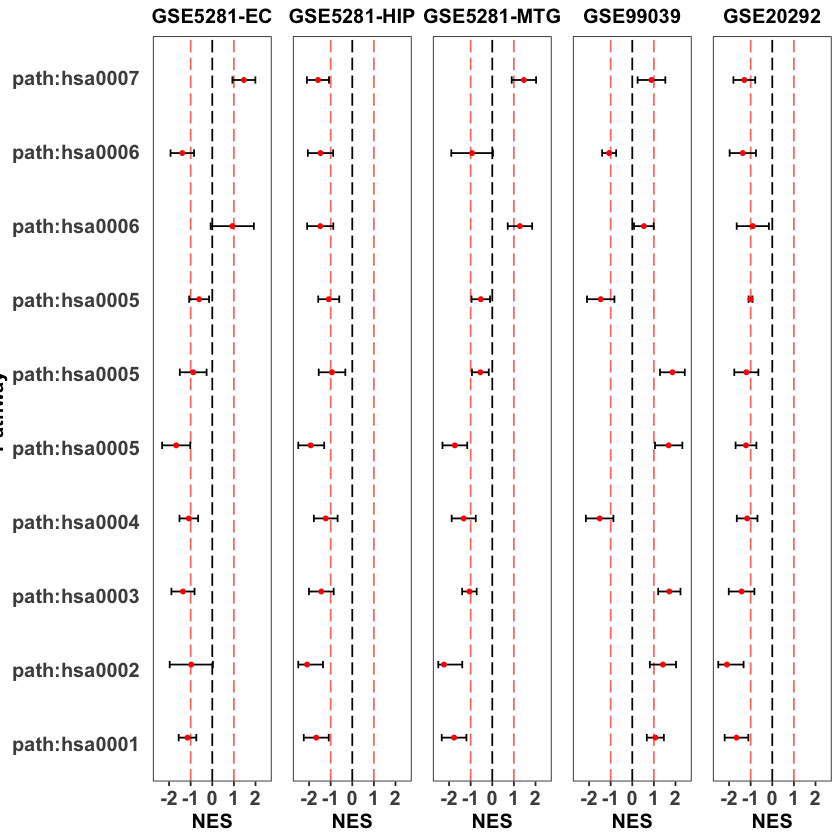

In [16]:
gridExtra::grid.arrange(grobs = c(
    list(
        ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +
        labs(y = "Pathway", title = "", x = "") +
        theme_minimal() +
        theme(
            panel.grid.major.x = element_blank(),
            plot.margin = unit(c(2, 0, 2, 5), "pt"),
            axis.text = element_text(face = "bold", size = 12),
            axis.title.y = element_text(face = "bold", size = 12)
        )
    ),
    plts
), nrow = 1, widths = c(1, rep(1, length(plts))))

The previous plot only shows the pathway score for each dataset. It does not provide us the overview for each disease. Therefore, we can plot the overlay of enrichment plots for all datasets with the same disease (group) using the following script.

In [17]:
# Get the list of datasets that belong to one certain disease
groups <- list(
    "ALZHEIMER" = c("GSE5281-EC", "GSE5281-HIP", "GSE5281-MTG"),
    "PARKINSON" = c("GSE99039", "GSE20292")
)

# Combine the data
allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"

# Get the combined data for each group of disease
for (cat in names(groups)) {
    allCombinedData$disease[allCombinedData$dataset %in% groups[[cat]]] <- cat
}

selected_pathways <- allCombinedData$pathway %in% picked.pathways.names
allCombinedData <- allCombinedData[selected_pathways, , drop = FALSE]

# Plot the boxplot for each pathway using the combined data,
# the plot for each disease will be stored in a list.
# Here, we want to plot the NES scores for two diseases.
# Therefore, the result list will have two elements.
plts <- lapply(split(allCombinedData, allCombinedData$disease), function(data) {
    data$pathway <- factor(data$pathway, levels = picked.pathways.names[length(picked.pathways.names):1])

    ggplot(data = data, mapping = aes(x = NES, y = pathway, group = dataset, col = dataset, fill = dataset)) +
        theme_minimal() +
        geom_point(position = position_dodge(0.7)) +
        geom_rect(
            aes(
                xmin = -Inf, xmax = Inf, ymin = as.numeric(pathway) - 0.5, ymax = as.numeric(pathway) + 0.5
            ),
            fill = ifelse((as.numeric(data$pathway) %% 2 == 0), "white", "#eeeeee"),
            color = "white"
        ) +
        geom_point(position = position_dodge(0.7)) +
        geom_vline(xintercept = c(-1, 1), colour = "#FA8072", linetype = "longdash") +
        geom_vline(xintercept = c(0), colour = "grey", linetype = "solid") +
        geom_errorbarh(height = .3, aes(xmin = min, xmax = max), position = position_dodge(0.7)) +
        theme_bw() +
        xlim(-2.5, 2.5) +
        theme(
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            plot.margin = unit(c(5, 5, 5, 5), "pt"),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
            axis.text.x = element_text(face = "bold", size = 12),
            axis.title.x = element_text(face = "bold", size = 12),
            legend.position = "top",
            legend.title = element_blank(),
            legend.text = element_text(face = "bold", size = 10)
        ) +
        guides(color = guide_legend(ncol = 1)) +
        labs(title = data$disease[1])
})

plotsAllLegends <- list()
plotsAllTitles <- list()

for (j in 1:length(plts)) {
    p <- plts[[j]]
    legendP <- get_legend(p)
    titleP <- get_title(p)

    plotsAllLegends[[j]] <- legendP
    plotsAllTitles[[j]] <- titleP
}

plotsWithoutLegend <- lapply(plts, function(plt) {
    plt + theme(
        legend.position = "none",
        title = element_blank(),
        plot.title = element_blank()
    )
})

gs_titles <- lapply(plotsAllTitles, function(p)
    as_ggplot(p) + theme(
        legend.margin = margin(c(0, 0, 0, 0))
    ))

gs_legends <- lapply(plotsAllLegends, function(p)
    as_ggplot(p) + theme(
        legend.margin = margin(c(0, 0, 0, 0))
    ))

listAll <- c(gs_titles, gs_legends, c(
    list(
        ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +
            labs(y = "Pathway", title = "", x = "") + theme_minimal() +
            theme(
                panel.grid.major.x = element_blank(),
                plot.margin = unit(c(2, 0, 2, 5), "pt"),
                axis.text = element_text(face = "bold", size = 12),
                axis.title.y = element_text(face = "bold", size = 12)
            )
    ),
    plotsWithoutLegend
))


After getting the plot for each disease, we can arrange the plots in one row using the `gridExtra` function available in the `cowplot` package.

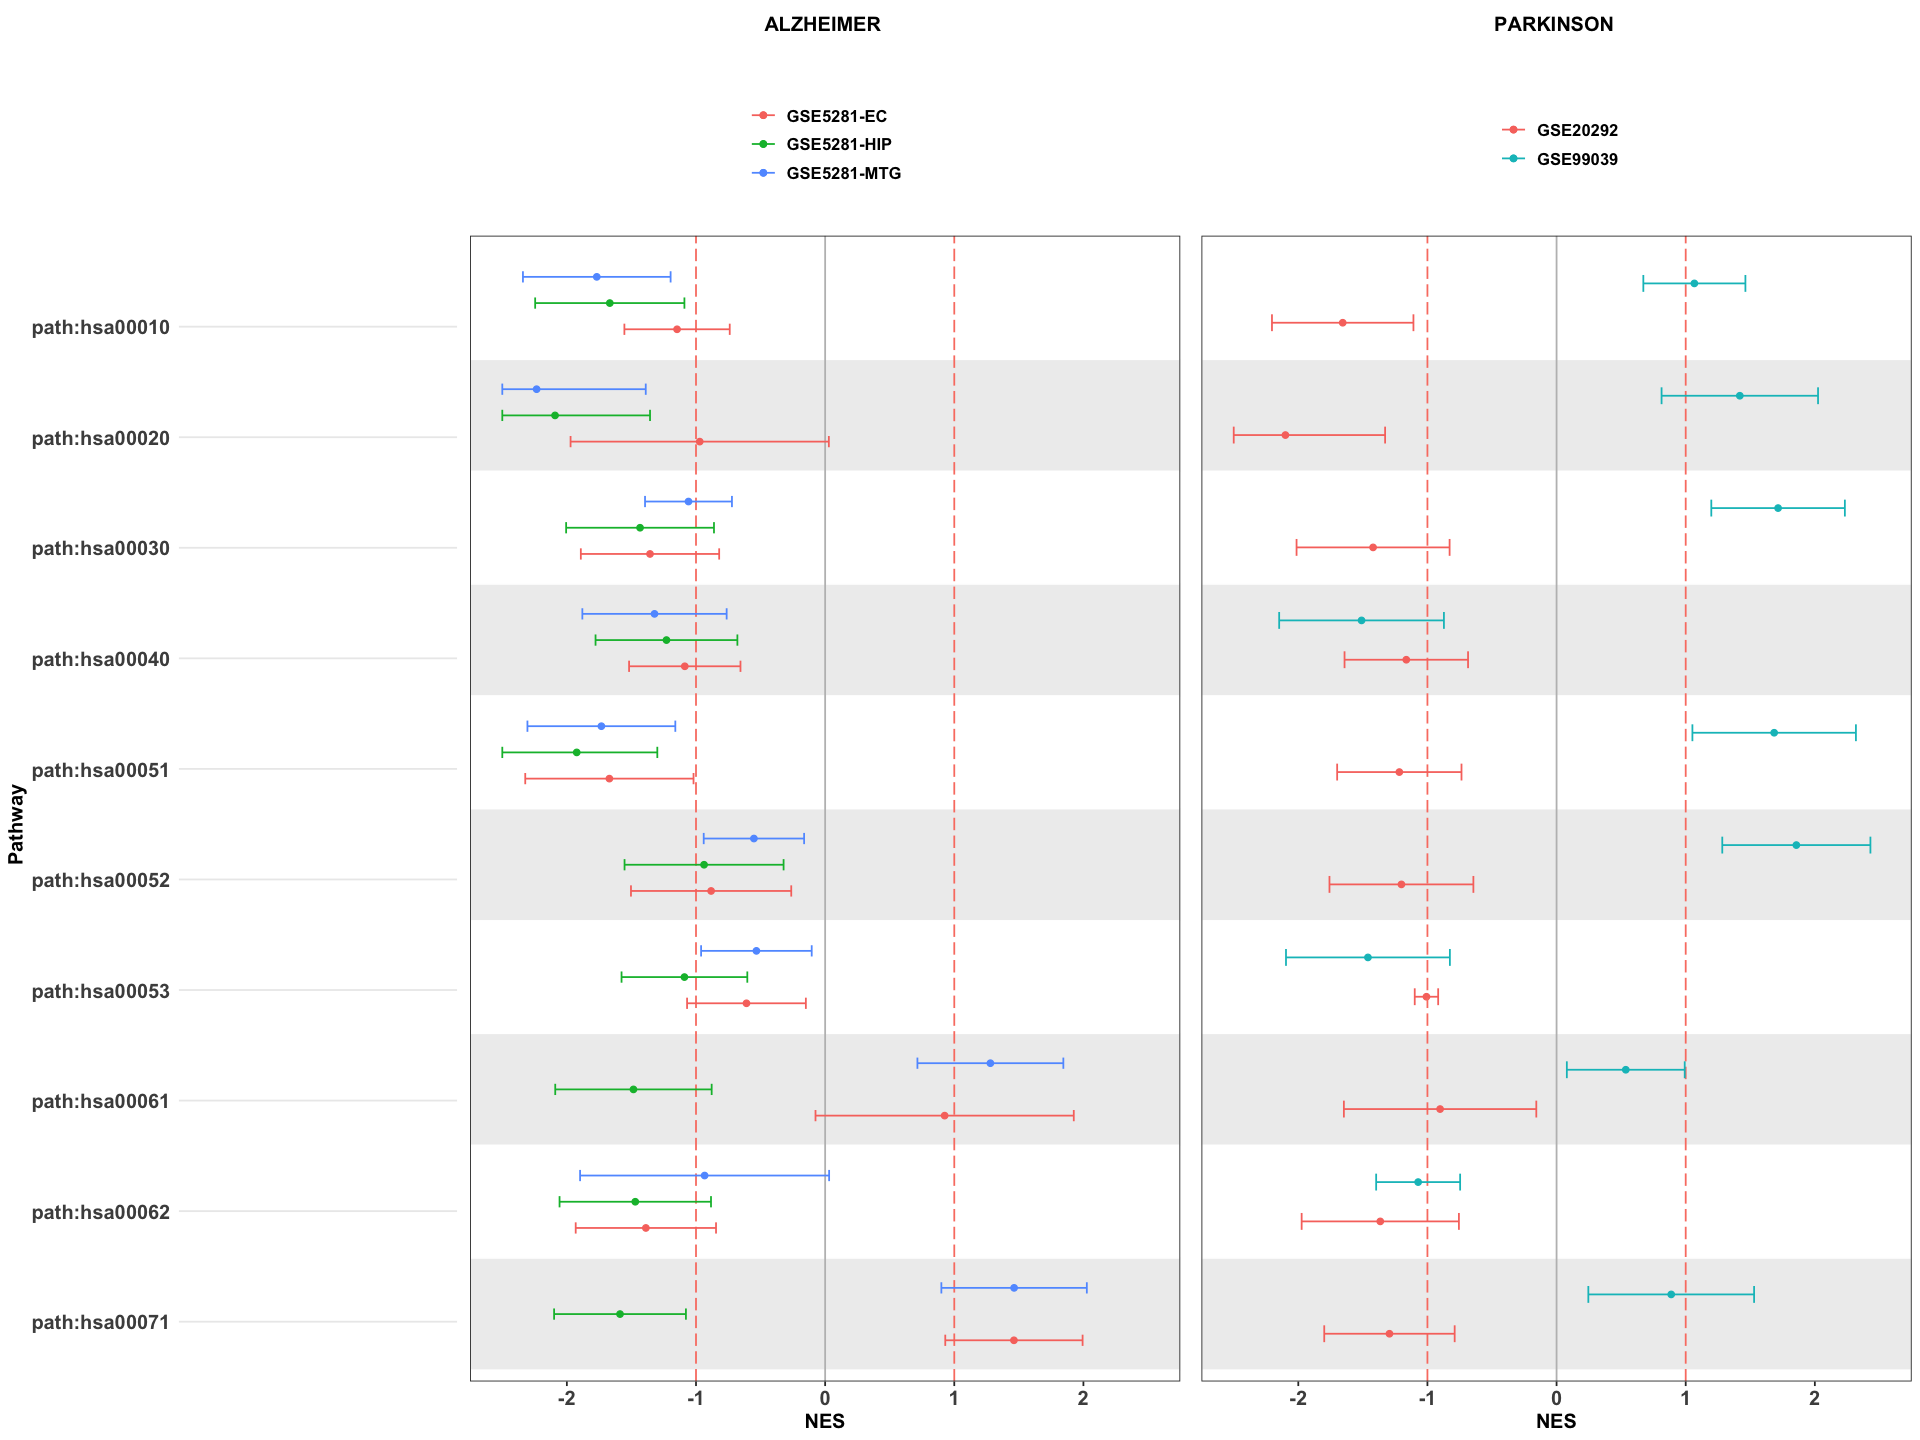

In [49]:
options(repr.plot.width = 16, repr.plot.height = 12)

gridExtra::grid.arrange(
    grobs = listAll,
    widths = c(5, rep(8, 2)),
    heights = c(0.4, 1.1, 8),
    layout_matrix = rbind(
        c(NA, rep(1:2)),
        c(NA, rep(3:4)),
        c(rep(5:7))
    )
)

From the figure above, we see that the same pathway in different datasets has different enrichment scores. The score might be significant in one dataset but it is not significant in other datasets. Therefore, it is necessary to perform meta-analysis to increase the statistical power of each pathway.

We can also plot either a Venn diagram or a Heatmap to show the differences between the pathway analysis results of different datasets. For Venn diagram, we can still utilize the function `plotVenn` which is previously used in submodule 4. 

In [42]:
#' @ description This function generates a Venn diagram to visualize the overlap of differentially expressed genes or features
#'                 between multiple sets of results.
#'
#' @param aResults A list containing multiple sets of differential expression analysis results.
#'                 Each element in the list should be a data frame or a tibble with columns representing
#'                 differentially expressed genes or features and relevant statistics.
#' @param pThreshold The significance threshold for filtering differentially expressed genes (default: 0.05).
#' @param useFDR A logical value indicating whether to use normal p-value or FDR p-value to filter out the DE genes (default: TRUE).#' @param labels A named vector of labels for genes. Default is `NULL`.
#' @param stat The statistical metric to use for filtering genes (default: "logFC" for log-fold change).
#' @param statThreshold The threshold value for the chosen statistical metric to filter differentially expressed genes (default: 0).
#' @param topToList The number of top differentially expressed genes or features to include in the Venn diagram (default: 10).
#' @param resultType The type of result to consider (default: "gene"). Options include "gene" or "feature".
#'
#' @return A Venn diagram displaying the overlap of differentially expressed genes or features among the specified result sets.

plotVenn <- function(aResults, pThreshold = 0.05, useFDR = TRUE, stat = "logFC", statThreshold = 0) {
    if (length(aResults) < 2) {
        stop("The number of DE results must be at least 2.")
    }

    for (Res in aResults) {
        if (useFDR && !("pFDR" %in% colnames(Res))) {
            stop("The F DR adjusted p-value column is not in the results data frame.")
        } else {
            if (!("p.value" %in% colnames(Res))) {
                stop("The p.value column is not in the results data frame.")
            }
        }

        if (!stat %in% colnames(Res)) {
            stop("The statistic column is not in the results data frame.")
        }
    }

    plotDat <- lapply(aResults, function(Res) {
            filtered_df <- filter(data.frame(Res),
                abs(.data[[stat]]) > statThreshold & (
                    if (useFDR) {
                        .data$pFDR < pThreshold
                    } else {
                        .data$p.value < pThreshold
                    }
                )
            )
            filtered_df[["ID"]]
    })
    
    if (is.null(names(plotDat))) {
        names(plotDat) <- paste0("Dataset ", seq_along(plotDat))
    }
    pR <- ggvenn::ggvenn(plotDat,
           fill_color = c(
               "#316b9d",
               # "#fce397",
               # "#99cc83",
               "#f77a65",
               "#a6a1d0",
               "#fea9c4",
               "#74e7bc",
               "#febb73",
               "#1db4db",
               "#ffc5a6",
               "#b6c9fa",
               "#ee5437"),
           stroke_size = 0.5,
           set_name_size = 4,
           fill_alpha = 0.75
    ) 
    
    xrange <- layer_scales(pR)$x$range$range
    yrange <- layer_scales(pR)$y$range$range


    pR <- pR + ggplot2::theme(plot.margin = margin(0, 0, 0, 0, "pt")) +
        ggplot2::annotate(geom = "text", x = xrange[2] + 0.1, y = yrange[2] + 0.1, label = NULL,
                        color = "black", hjust = 0, vjust = 1, fontface = 2) +
        ggplot2::annotate(geom = "text", x = xrange[2] + 0.1, y=yrange[2] + 0.1, label = NULL,
                        color = "black", hjust = 0, vjust = 1) +
        scale_x_continuous(limits = c(xrange[1], xrange[2] + 1.5))

    return(pR)
}


To prepare plotting data for the Venn diagram from the pathway analysis results of datasets of the same disease, we will use the following code.

In [43]:
GSE52810_result <- plots.enrichment.data[["GSE5281-EC"]]$res
GSE52810_result$p.value <- GSE52810_result$pval
GSE52810_result$ID <- GSE52810_result$pathway

GSE5281H_result <- plots.enrichment.data[["GSE5281-HIP"]]$res
GSE5281H_result$p.value <- GSE5281H_result$pval
GSE5281H_result$ID <- GSE5281H_result$pathway

GSE5281M_result <- plots.enrichment.data[["GSE5281-MTG"]]$res
GSE5281M_result$p.value <- GSE5281M_result$pval
GSE5281M_result$ID <- GSE5281M_result$pathway

PAResults <- list("GSE5281-EC" = GSE52810_result, "GSE5281-HIP" = GSE5281H_result, "GSE5281-MTG" = GSE5281M_result)

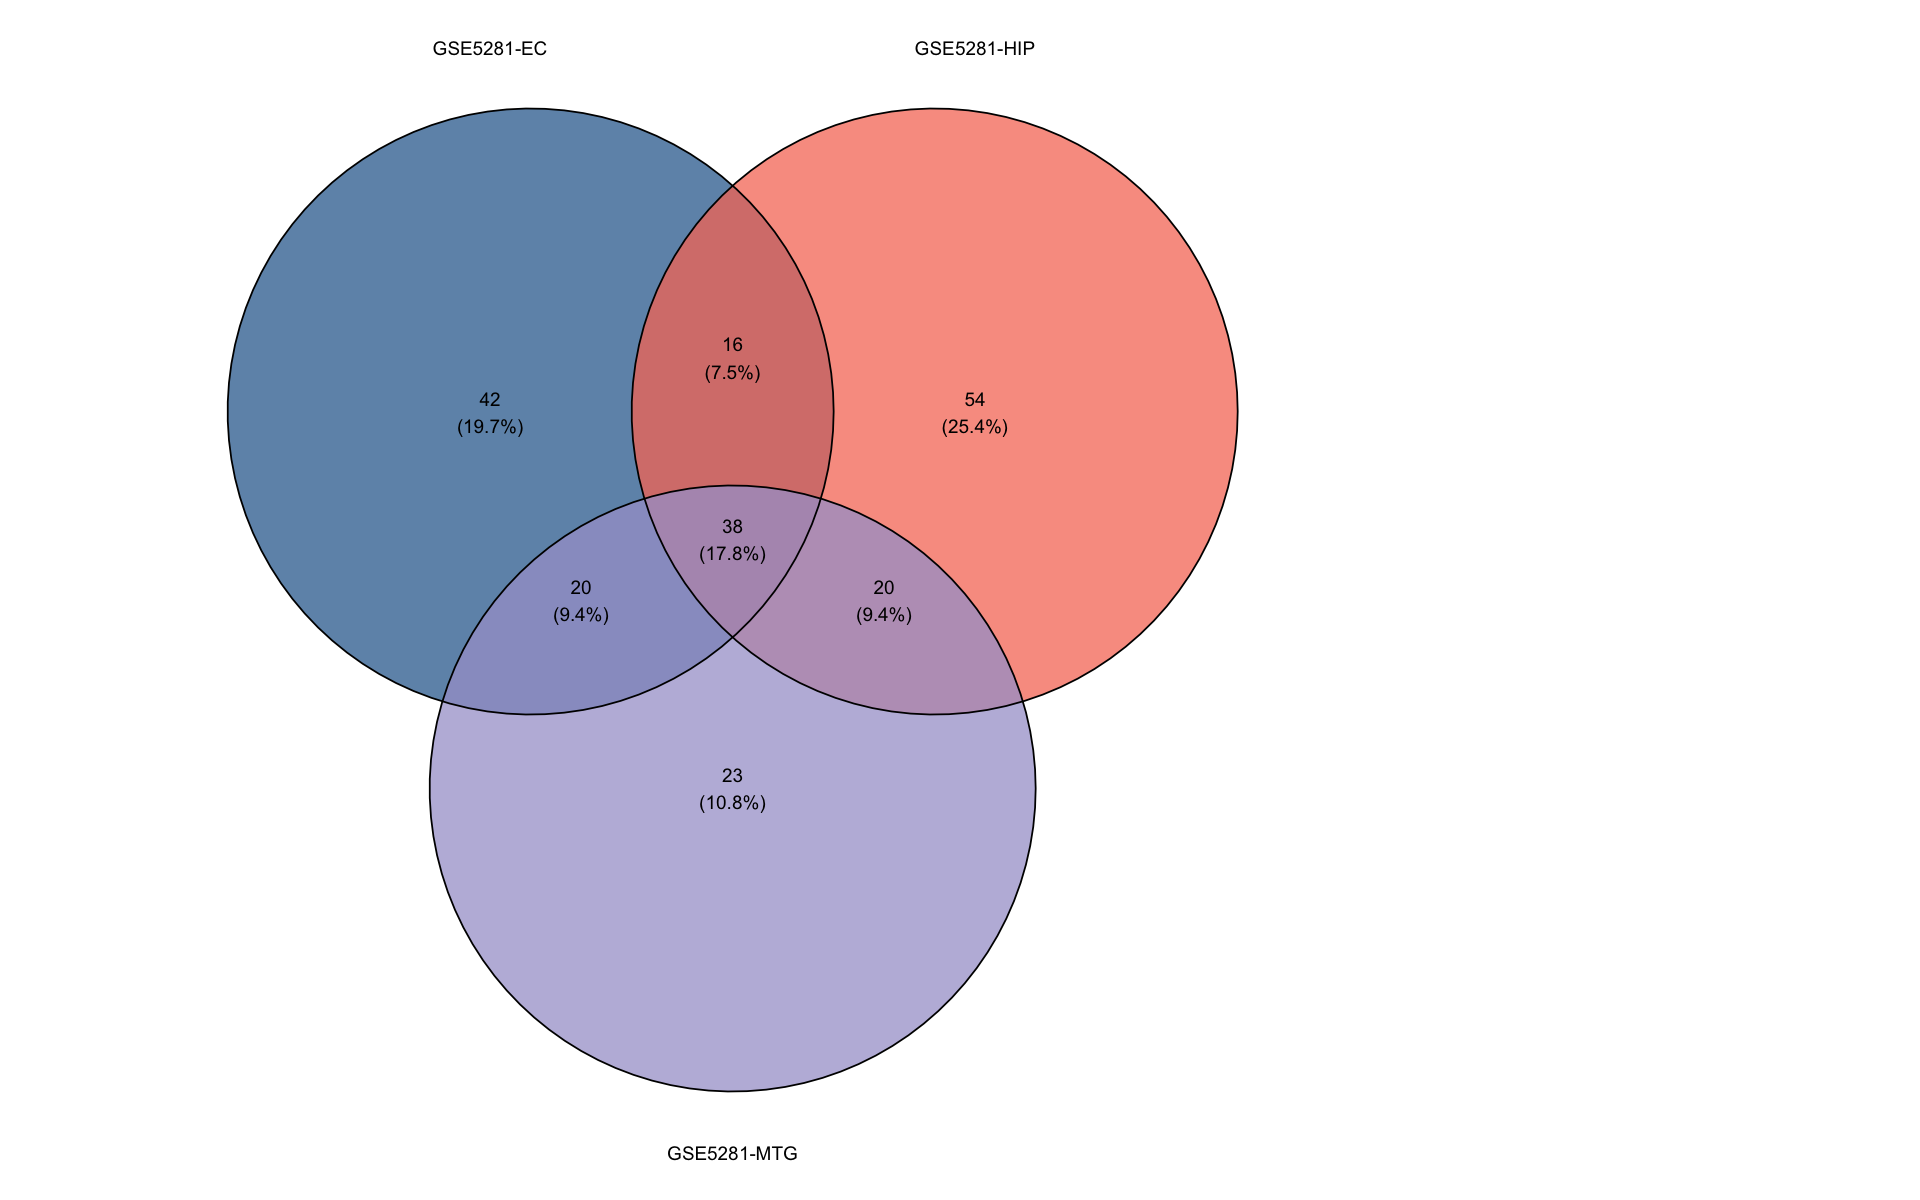

In [45]:
options(repr.plot.width = 16, repr.plot.height = 10)
# Create the Venn pathway for pathway results of different datasets.
plotVenn(PAResults, useFDR = FALSE, stat = "p.value")

To plot a Heatmap for pathway analysis results, we can use the function bellow:

In [46]:
#' @description This function generates a heatmap visualizing pathway analysis results.
#'
#' @param resultsList List of pathway analysis results.
#' @param yAxis Column to be used for the y-axis of the heatmap (default is "ID").
#' @param negLog10pValueLims Limits for the negative logarithm base 10 of p-values (default is c(0, 5)).
#' @param useFDR Logical, whether to use False Discovery Rate (FDR) for p-values (default is TRUE).
#' @param selectedPathways Vector of selected pathway IDs to include in the plot (default is NULL).
#'
#' @return The function returns the heatmap plot.

plotPathwayHeatmap <- function(resultsList, yAxis = "ID", negLog10pValueLims = c(0, 5), useFDR = TRUE, selectedPathways = NULL) {
    
    if (!is.null(selectedPathways)) {
      resultsList <- lapply(resultsList, function(df) df[df$ID %in% selectedPathways,])
    }
    
    studyIDs <- names(resultsList)

    if (any(sapply(studyIDs, is.null))) {
        stop("The names of the input list should be specified.")
    }
    
    checkNS <- lapply(resultsList, function(data) c("NES") %in% colnames(data))
    
    resultsList <- lapply(seq_along(checkNS), function(i) {
      if (!checkNS[[i]]) {
        df <- resultsList[[i]]
        df$NES <- rep(.Machine$double.eps, nrow(df))
        resultsList[[i]] <- df
      } else {
        resultsList[[i]]
      }
    })

    cols_list <- lapply(resultsList, function(data) colnames(data))

    if (!all(sapply(cols_list, function(x) c("ID", "NES", "p.value") %in% x))) {
        stop("All dataframes in the input list must have 'ID', 'NES', and 'p.value' columns.")
    }
                    
    rows_list <- lapply(resultsList, function(data) as.vector(unlist(data$ID)))
    
    if (!all(lengths(rows_list) == length(rows_list[[1]]))) {
        stop("All dataframes in the input list must have the same number of rows.")
    }
    
    initial_names <- sort(as.vector(unlist(resultsList[[1]]$ID)))

    if (!all(sapply(rows_list, function(x) all.equal(sort(x), initial_names)))) {
        stop("All dataframes in the input list must have the same set of pathways.")
    }

    plotData <- lapply(1:length(resultsList), function(i) {
        data <- resultsList[[i]]
        data <- data[, c("ID", "NES", "p.value")]
        data$dataset <- studyIDs[i]
        data$Direction <- ifelse(data$NES <= 0, "Negative", "Positive")
        data$abs.NES <- abs(as.vector(data$NES))
        as.data.frame(data)
    }) 
    plotData <- do.call(plotData, what = rbind)
    
    plotData$Direction <- factor(plotData$Direction, levels = c("Positive", "Negative"))

    
    plotData$logP <- if (useFDR) -log10(plotData$pFDR) else -log10(plotData$p.value)

    grouped_data <- arrange(
        dplyr::summarize(
            group_by(plotData, ID),
            avgLogP = mean(logP, na.rm = TRUE)
        ),
        avgLogP
    )
    
    pathwayOrder <- pull(grouped_data, ID)

    plotData$dataset <- factor(plotData$dataset, levels = studyIDs)
    plotData$ID <- factor(plotData$ID, levels = pathwayOrder)
    yLabels <- pull(arrange(unique(select(plotData, "ID", sym(yAxis))), as.numeric(ID)), sym(yAxis))

    scaleMinMax <- function(x, minx, maxx) {
        x[x < minx] <- minx
        x[x > maxx] <- maxx
        x
    }

    if (yAxis == "ID") {
        plotData$yLabel <- plotData$ID
    }else {
        plotData$yLabel <- plotData$name
    }

    plotData$p.value.scaled <- scaleMinMax(abs(log10(
        if (useFDR) plotData$pFDR else plotData$p.value)), 
            negLog10pValueLims[1], negLog10pValueLims[2])


    ggplot(plotData, aes(y = .data$ID, x = factor(.data$dataset))) +
        geom_tile(
            aes(fill = .data$p.value.scaled)
        ) +
        scale_fill_continuous(
            low = "white",
            high = "#CD5C5C",
            limits = c(negLog10pValueLims[1], negLog10pValueLims[2]),
            breaks = c(negLog10pValueLims[1], (negLog10pValueLims[1] + negLog10pValueLims[2]) / 2, negLog10pValueLims[2]),
            guide = guide_colorbar(
                title = paste0("-log10", ifelse(useFDR, " pFDR", " p-value"))
            )
        ) +
        new_scale_fill() +
        geom_point(
            aes(
                fill = .data$Direction,
                size = .data$abs.NES
            ),
            shape = 21,
            color = "white",
            stroke = 0.5
        ) +
        scale_y_discrete(
            labels = yLabels
        ) +
        scale_size_continuous(
            guide = guide_legend(override.aes = list(shape = 21, fill = "gray50"))
        ) +
        scale_fill_manual(
            values = c("Positive" = "#FFAA1D", "Negative" = "#72A0C1"),
            guide = guide_legend(override.aes = list(shape = 21, size = 8), title = element_text("Sign"))
        ) +
        labs(
            size = "Normalized score",
            x = "",
            y = "") +

        theme_bw() + 
        
      
      ggplot2::theme(plot.title = element_text(hjust = 0.5))
}

In [47]:
# Create a pathway list to plot, here we will use the top 30 pathways (based on NES) of the GSE5281-EC dataset
all_pathways <- PAResults[[1]][order(PAResults[[1]]$p.value)]
selectedPathways <- all_pathways[1:30]$ID
selectedPathways

[1] "path:hsa04080" "path:hsa04728" "path:hsa04724" "path:hsa05022"
 [5] "path:hsa04261" "path:hsa04723" "path:hsa05032" "path:hsa04726"
 [9] "path:hsa05033" "path:hsa04713" "path:hsa00970" "path:hsa04727"
[13] "path:hsa04961" "path:hsa04721" "path:hsa04970" "path:hsa01100"
[17] "path:hsa05204" "path:hsa04742" "path:hsa05213" "path:hsa03083"
[21] "path:hsa04911" "path:hsa04330" "path:hsa05215" "path:hsa05211"
[25] "path:hsa04520" "path:hsa04066" "path:hsa04550" "path:hsa04392"
[29] "path:hsa04390" "path:hsa04110"

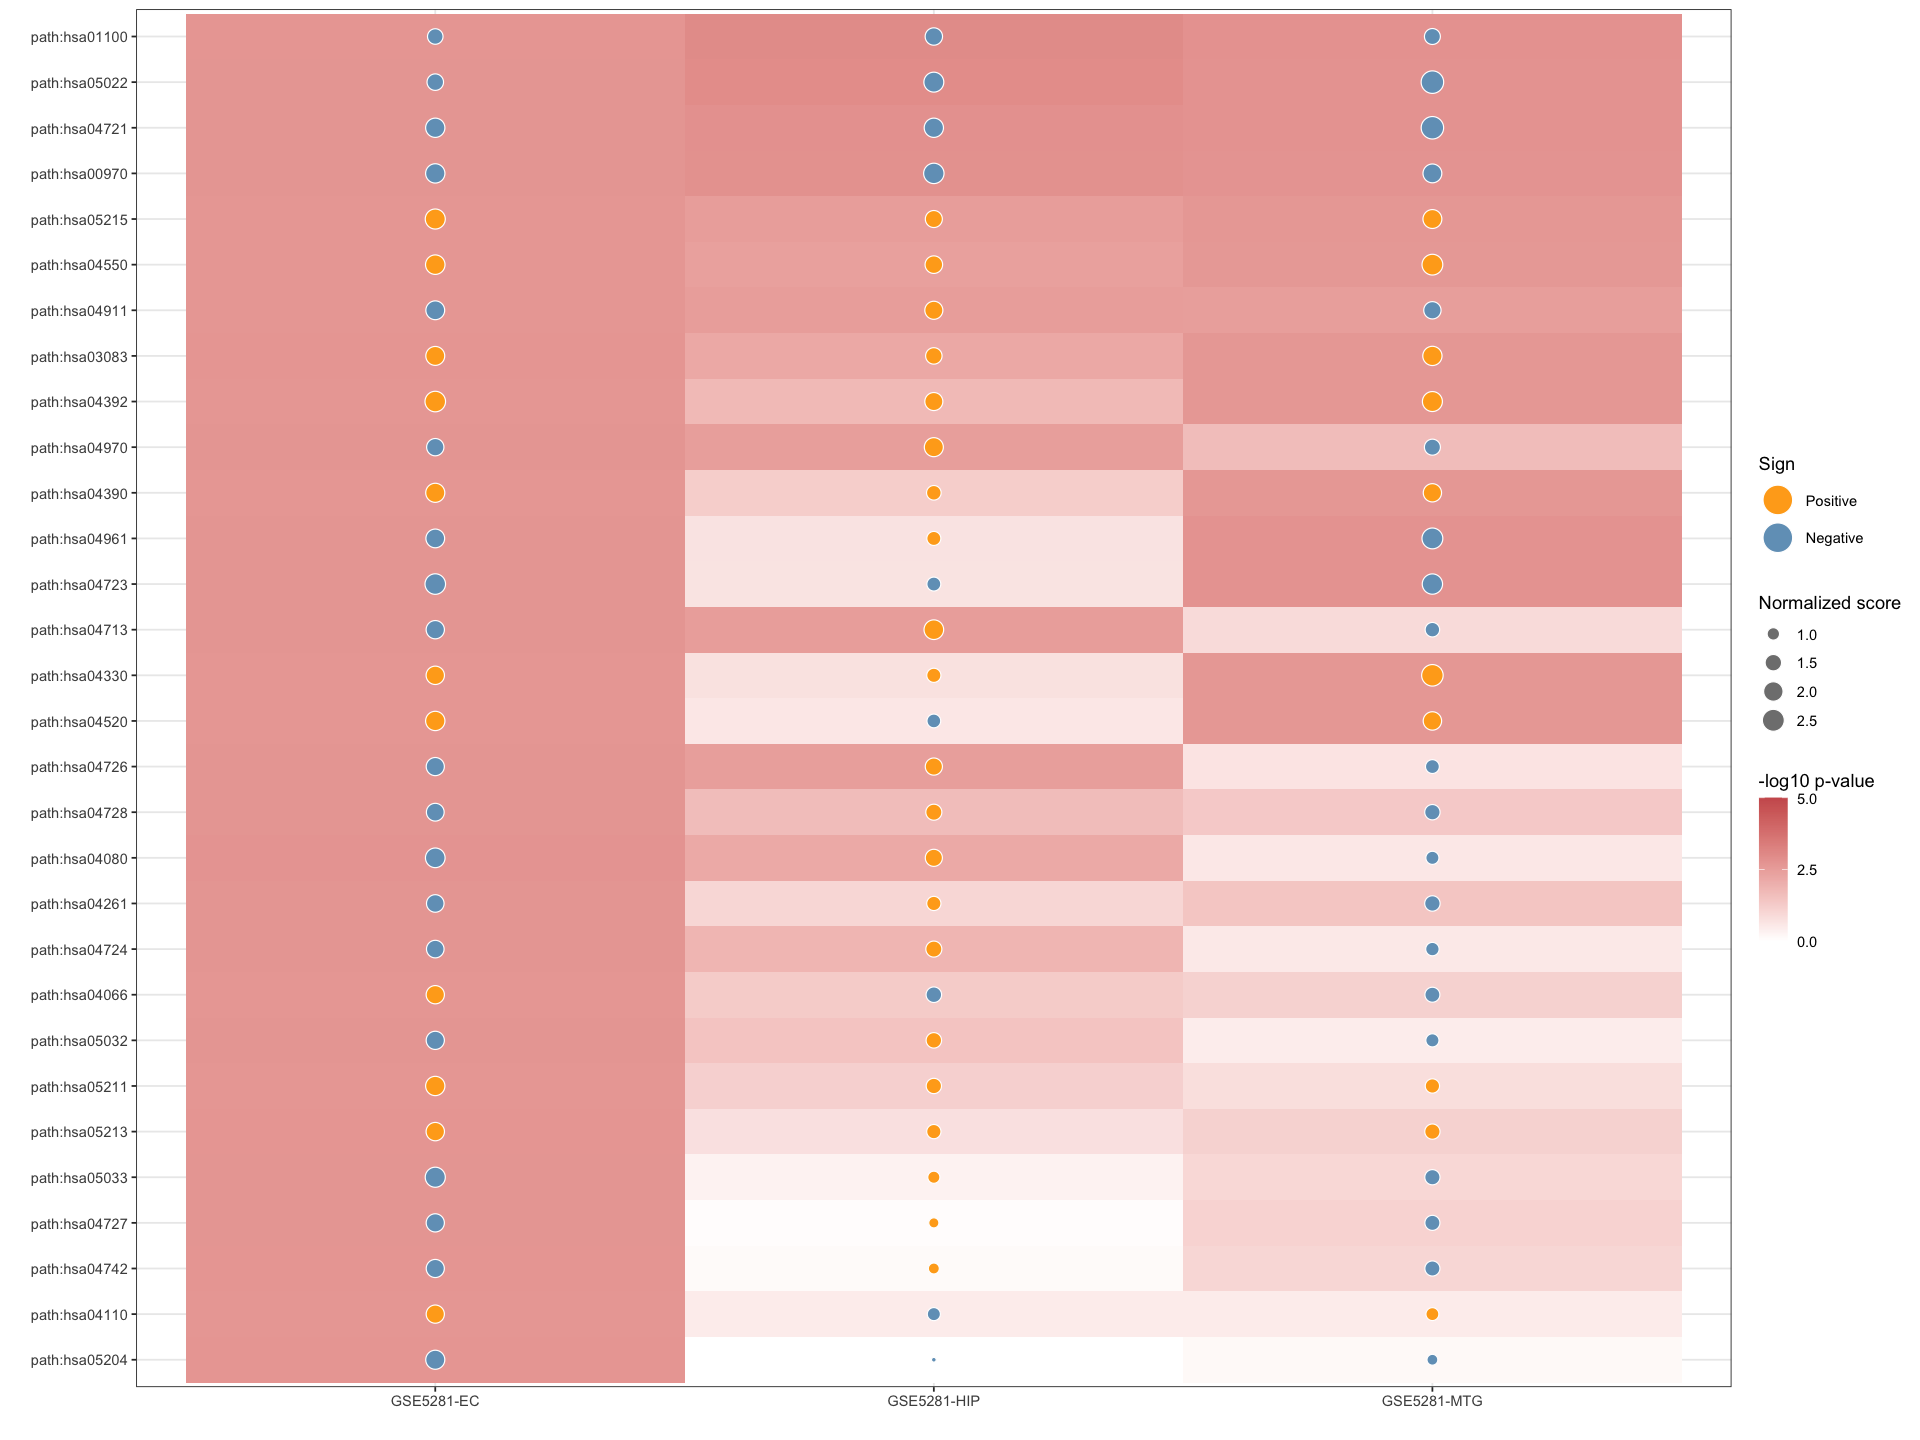

In [48]:
options(repr.plot.width = 16, repr.plot.height = 12)
# Create a Heatmap for pathway analysis results of different datasets
plotPathwayHeatmap(PAResults, yAxis = "ID", useFDR = FALSE, selectedPathways = selectedPathways)

## Meta-Analysis
In this section, we will perform a generic inverse variance meta-analysis using `metagen` function available in the `meta` package. `metagen` is a statistical method used in meta-analysis to combine the results of multiple studies that have measured the same effect size, typically using different sample sizes and study designs. This method involves pooling the effect sizes from each study, weighted by the inverse of their variance, in order to obtain an overall estimate of the effect size and its confidence interval.

The basic idea behind the generic inverse variance meta-analysis is that studies with larger sample sizes, which tend to have smaller variance, should be given more weight in the meta-analysis than studies with smaller sample sizes, which tend to have larger variance. This is achieved by weighting each study's effect size estimate by the inverse of its variance, which is a measure of the precision of the estimate.

The generic inverse variance meta-analysis is often used in meta-analyses of randomized controlled trials or observational studies, where the effect size is typically reported as a mean difference or a standardized mean difference between two groups, or as a hazard ratio or odds ratio for a binary outcome. This method assumes that the effect size estimates from each study are independent and normally distributed around the true effect size, and that there is no systematic bias or heterogeneity in the effect size estimates across studies.

In [25]:
# Get combined data from the individual datasets in plots.enrichment.data
allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"

# Assign diseases to the combined data based on dataset grouping
for (cat in names(groups)) {
    allCombinedData$disease[allCombinedData$dataset %in% groups[[cat]]] <- cat
}

# Performing meta-analysis on groups of datasets with the same disease
metaESRes <- lapply(split(allCombinedData, ~disease + pathway), function(data) {
    # Drop rows with missing data
    data <- drop_na(data)

    # Perform meta-analysis using the metagen function
    res <- suppressWarnings(meta::metagen(
        data = data,
        studlab = pathway,
        TE = NES,
        seTE = NES.sd,
        sm = "SMD",
        n.e = NULL,
        #n.e = sample.size,
        method.tau = "REML",
        hakn = TRUE
    ))

    # Extract combined NES and related information
    NES.combined <- res$TE.fixed
    NES.combined.sd <- res$seTE.fixed

    # Calculate p-value
    pval <- pnorm((ifelse(NES.combined > 0, 1, -1) - NES.combined)/NES.combined.sd)
    if (NES.combined < 0) pval <- 1 - pval

    # Create a data frame with meta-analysis results
    data.frame(
        disease = data$disease[1],
        pathway = data$pathway[1],
        NES.combined = NES.combined,
        NES.combined.sd = NES.combined.sd,
        pval.combined = pval,
        count = nrow(data),
        stringsAsFactors = FALSE
    )
}) 

metaESRes <- do.call(rbind, metaESRes)
metaESRes <- as.data.frame(metaESRes)

In [26]:
names(allCombinedData)

[1] "pathway"      "pval"         "padj"         "ES"           "NES"         
 [6] "nMoreExtreme" "size"         "leadingEdge"  "pvals"        "dataset"     
[11] "NES.sd"       "min"          "max"          "disease"

In [27]:
class(allCombinedData$size)

[1] "integer"

To use the `metagen` function, we need to pass the following arguments:

- `TE`: A numeric vector specifying the estimate of treatment effect, e.g., log hazard ratio or risk difference.
- `seTE`: A numeric vector specifying the standard error of treatment estimate.
- `studlab`: An optional vector with study labels.
- `data`: An optional data frame containing the study information.
- `sm`: A character string specifying underlying summary measure, e.g., "RD", "RR", "OR", "ASD", "HR", "MD", "SMD", or "ROM".
- `n.e`: Number of observations in experimental group.
- `method.tau`: A character string specifying which method is used to estimate the between-study variance. Either "DL", "PM", "REML", "ML", "HS", "SJ", "HE", or "EB", can be abbreviated.
- `hakn`: A logical specifying whether method by Hartung and Knapp should be used to adjust test statistics and confidence intervals.

The `metagen` function returns an object of class c("metagen", "meta") contains the analysis results.

After performing a meta-analysis, we can calculate the adjusted p-value meta enrichment scores. We will use the function `p.adjust` to calculate adjusted P-values for multiple comparisons. The result is saved into a data frame.

In [28]:
# Computing adjusted meta p-values
metaEREes <- lapply(split(metaESRes, metaESRes$disease), function(r) {
    r$p.fdr <- p.adjust(p = r$pval.combined, method = "fdr")
}) 
metaEREes <- do.call(metaEREes, what = rbind)

In [29]:
head(metaEREes)

ALZHEIMER,0.009761007,0.0004572649,0.213454,0.3232397,0.0001296372,1,1.0000000,1,0.1141597,1,⋯,1.000000000,1.0000000000,1,1.0000000,0.08516152,1.0000000,0.01145729,1.000000000,0.07536595,1.00000000
PARKINSON,1.000000000,1.0000000000,1.000000,0.2114992,1.0000000000,1,0.7868743,1,0.4326686,1,⋯,0.002362955,0.0006755969,1,0.2639408,1.00000000,0.1081814,0.97905097,0.003792521,0.00139859,0.02825014


To use the `p.adjust` function, we need to pass the following arguments:

- `p`: Numeric vector of p-values (possibly with NAs). Any other R object is coerced by as.numeric.
- `method`: A character string specifying a correction method, can be one of these: "holm", "hochberg", "hommel", "bonferroni", "BH", "BY",  "fdr", "none".

The `p.adjust` function returns a numeric vector of adjusted p-values.

We can plot meta analysis result using the script that we have developed previously.

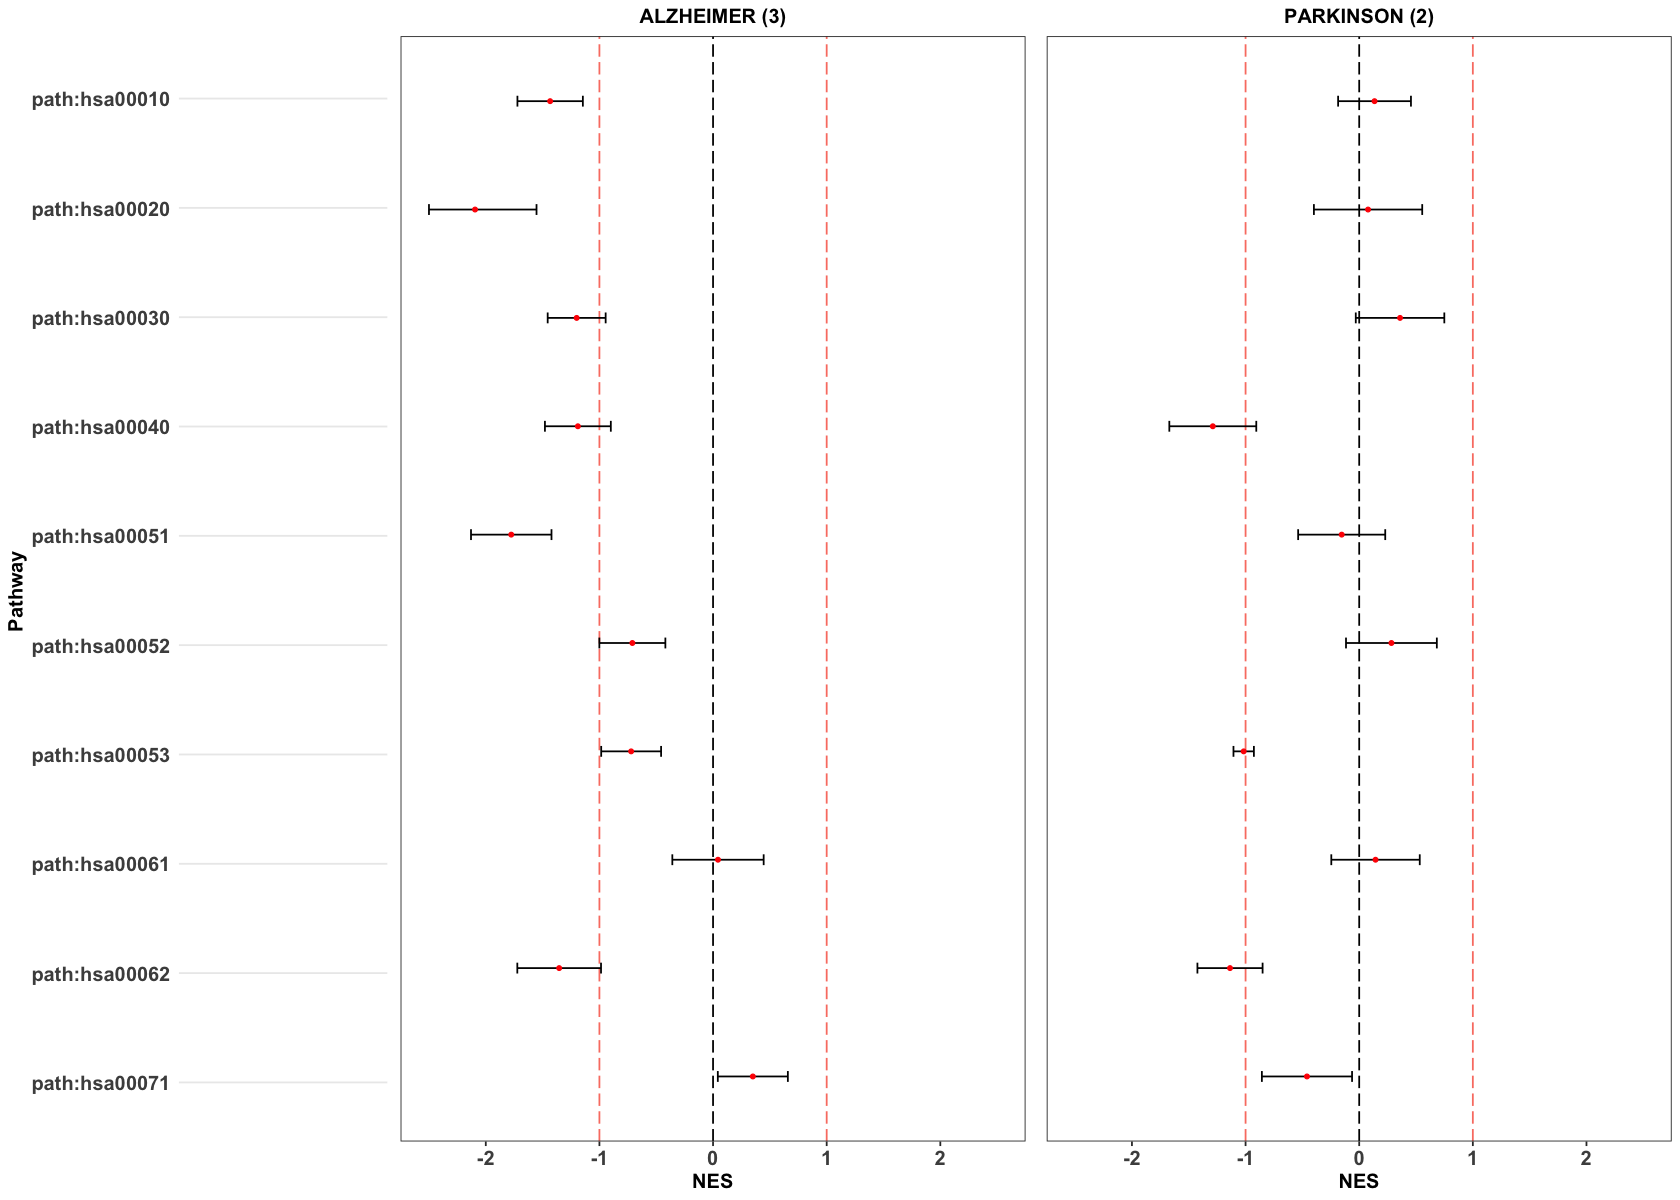

In [30]:
plts <- lapply(split(metaESRes, metaESRes$disease), function(plotDat) {
    plotDat <- data.frame(plotDat)
    rownames(plotDat) <- plotDat$pathway
    plotDat <- plotDat[picked.pathways.names, ]
    plotDat$pathway <- factor(plotDat$pathway,
                              levels = picked.pathways.names[length(picked.pathways.names):1])

    sd <- plotDat$NES.combined.sd
    sd[sd > 0.5] <- 0.5

    plotDat$min <- plotDat$NES.combined - sd * 2
    plotDat$max <- plotDat$NES.combined + sd * 2

    plotDat$min[plotDat$min < -2.5] <- -2.5
    plotDat$max[plotDat$max > 2.5] <- 2.5

    ggplot(plotDat, aes(y = pathway, x = NES.combined, xmin = min, xmax = max)) +
        theme_minimal() +
        geom_vline(xintercept = c(-1, 1), colour = "#FA8072", linetype = "longdash") +
        geom_vline(xintercept = c(0), colour = "black", linetype = "longdash") +
        geom_errorbarh(height = .1) + theme_bw() +
        geom_point(size = 1, color = "red") +
        theme(
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            plot.margin = unit(c(5, 5, 5, 5), "pt"),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
            axis.text.x = element_text(face = "bold", size = 12),
            axis.title.x = element_text(face = "bold", size = 12)
        ) +
        labs(x = "NES", title = paste0(plotDat$disease[1], " (", plotDat$count[1], ")")) +
        xlim(-2.5, 2.5)
})

options(repr.plot.width = 14, repr.plot.height = 10)

gridExtra::grid.arrange(
    grobs = c(
        list(
            ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +
                labs(y = "Pathway", title = "", x = "") +
                theme_minimal() +
                theme(
                    panel.grid.major.x = element_blank(),
                    plot.margin = unit(c(2, 0, 2, 5), "pt"),
                    axis.text = element_text(face = "bold", size = 12),
                    axis.title.y = element_text(face = "bold", size = 12)
                )
        ),
        plts
    ),
    nrow = 1,
    widths = c(0.6, rep(1, length(plts)))
)


From the above figure, we see that the enrichment scores produced from a meta-analysis using multiple datasets are more significant compared with the ones calculated from a single dataset.


We can now plot a Heatmap to compare the difference analysis results. We need to prepare the plot data first.

In [31]:
meta_results <- split(metaESRes, metaESRes$disease)$ALZHEIMER

# change the name of the columns in the result table for plotting
colnames(meta_results) <- c("disease", "ID", "NES", "NES.sd", "p.value", "count")
head(meta_results)

,disease,ID,NES,NES.sd,p.value,count
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
ALZHEIMER.path:hsa00010,ALZHEIMER,path:hsa00010,-1.4336101,0.1439536,1.297014e-03,3
ALZHEIMER.path:hsa00020,ALZHEIMER,path:hsa00020,-2.0944108,0.2704504,2.598096e-05,3
ALZHEIMER.path:hsa00030,ALZHEIMER,path:hsa00030,-1.2002335,0.1275423,5.821472e-02,3
ALZHEIMER.path:hsa00040,ALZHEIMER,path:hsa00040,-1.1895720,0.1449758,9.550263e-02,3
ALZHEIMER.path:hsa00051,ALZHEIMER,path:hsa00051,-1.7759065,0.1770860,5.892600e-06,3
ALZHEIMER.path:hsa00052,ALZHEIMER,path:hsa00052,-0.7100858,0.1452428,9.770366e-01,3


Now we will add the meta-result to the plot list and create a heatmap plot.

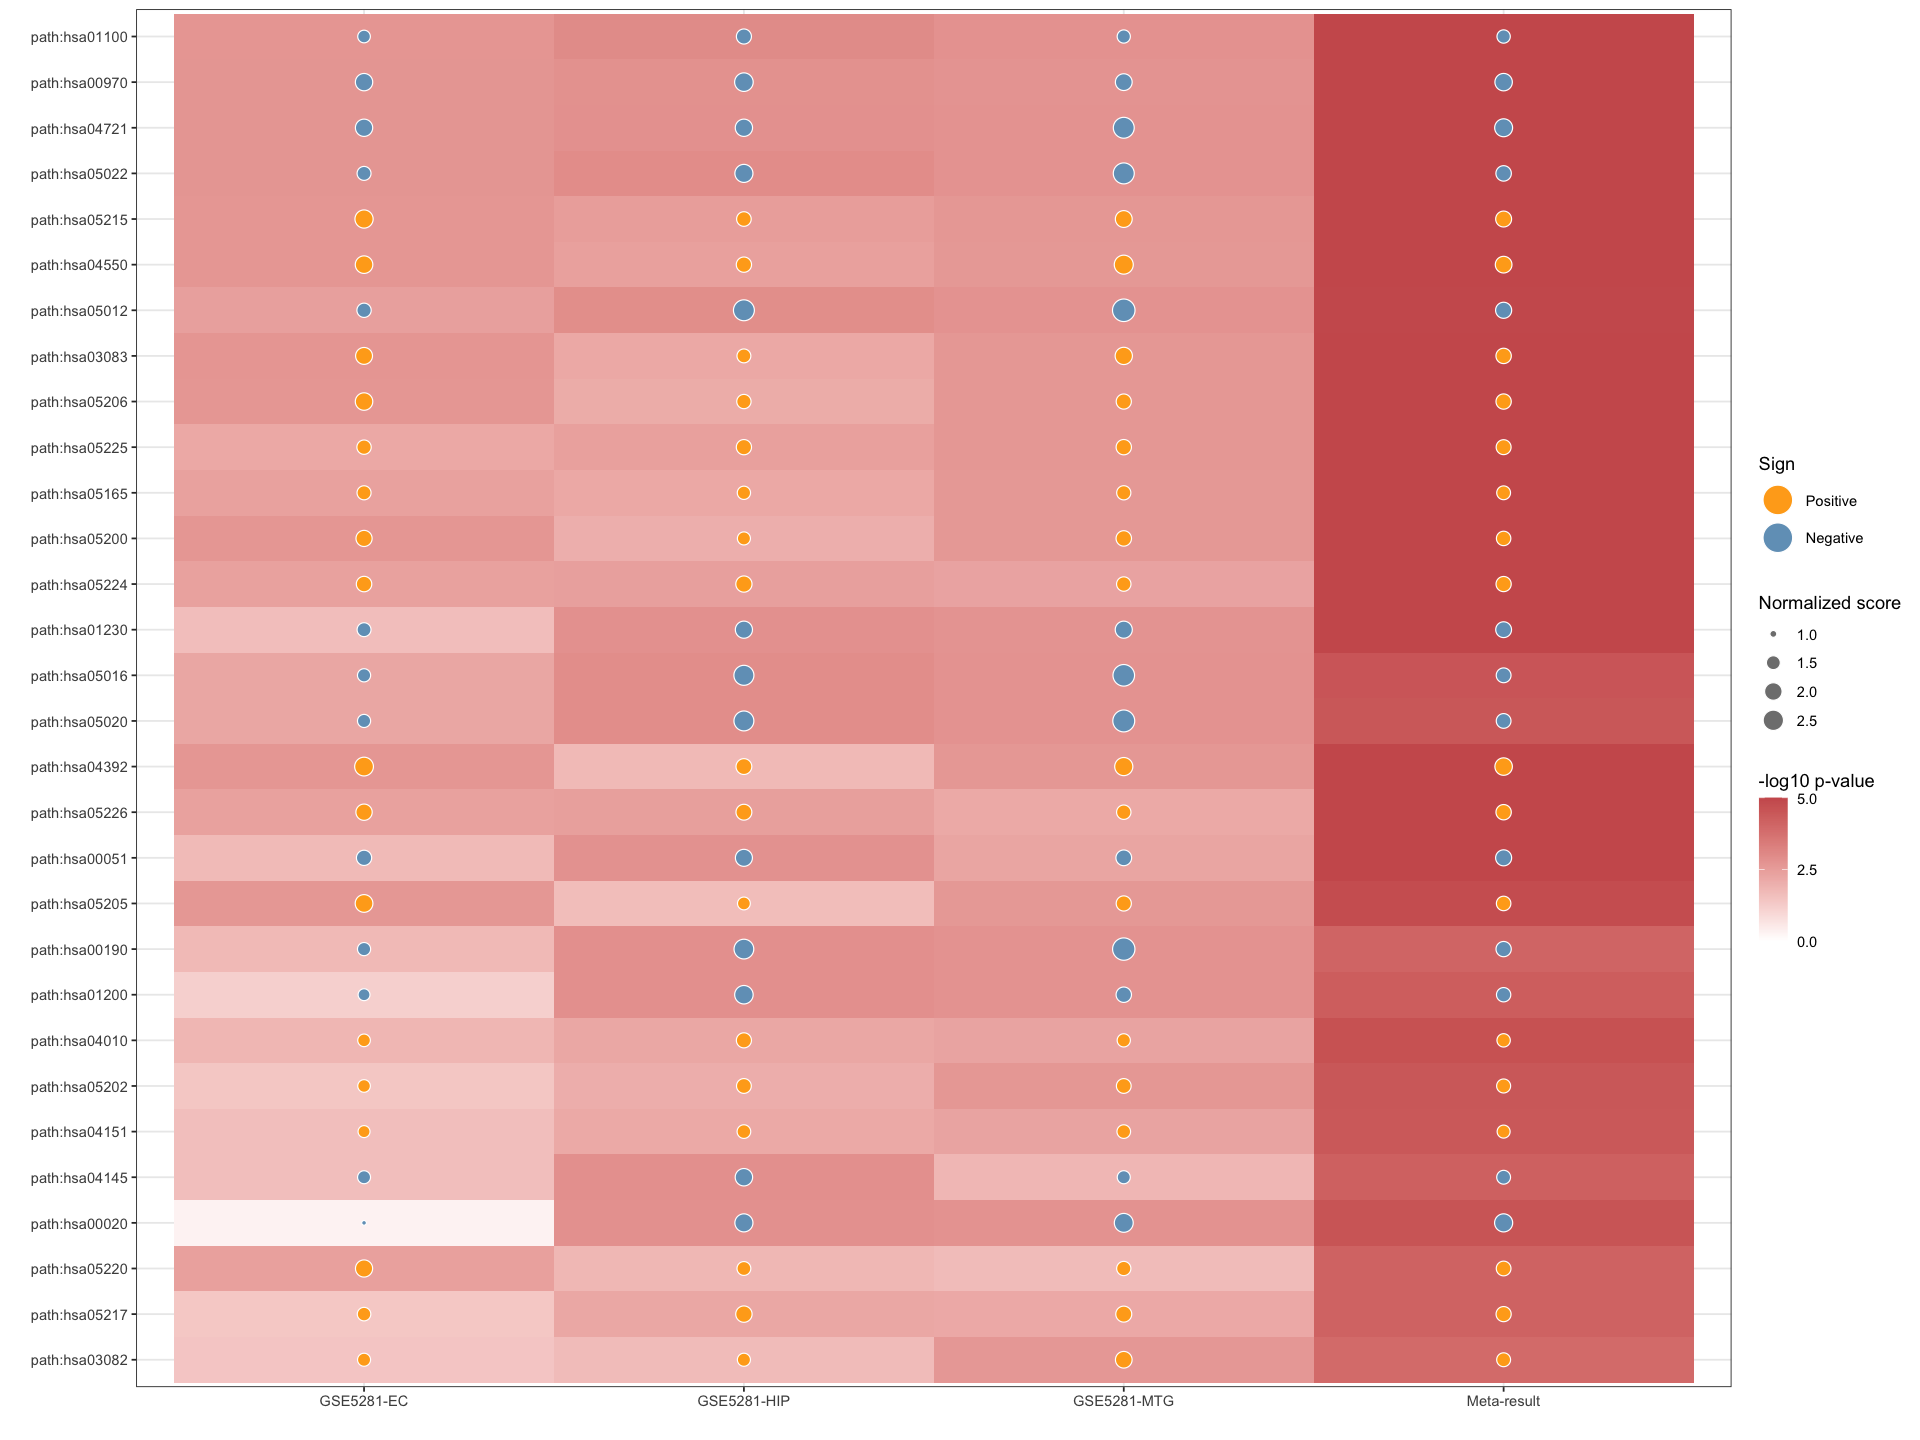

In [32]:
PAResults[["Meta-result"]] <- meta_results

pathway_IDs <- meta_results[order(meta_results$p.value), ]$ID
selectedPathways <- pathway_IDs[1:30]
# create the heatmap plot
options(repr.plot.width = 16, repr.plot.height = 12)

plotPathwayHeatmap(PAResults, yAxis = "ID", useFDR = FALSE, selectedPathways = selectedPathways)


# Conclusion

 In this course, we have successfully completed pathway analysis using omics data in five submodules that cover different aspects of bioinformatics analysis. The first submodule, Data Processing, introduces the fundamental concepts of preprocessing and quality control of microarray data obtained from Gene Expression Omnibus. The second submodule, Differential Expression Analysis, focuses on how to analyze gene expression data to identify genes that are differentially expressed between two or more conditions. The third submodule, Gene Set and Pathway shows us how to use different R libraries to obtain pathways and GO terms with associated gene lists. The fourth submodule, Enrichment Analysis, focuses on the identification of enriched biological pathways or functional categories within a set of genes of interest. Finally, the fifth submodule, Meta Analysis, covers the techniques of meta-analysis which is a statistical approach to combine the results of multiple independent studies. Overall, the cloud learning module provides a comprehensive and practical guide for researchers to analyze and interpret their genomic data using various bioinformatics tools and techniques.

In [33]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.6.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.6.0        meta_6.5-0          fgsea_1.28.0       
 [4] ggnewscale_0.4.9    ggvenn_0.1.10       ggplot2_3.4.4      
 [7] tidyr_1.3.0         dplyr_1.1.4         cowplot_1.1.2      
[10] matrixStats_1.2.0   stringr_1.5.1       BiocManager_1.30.22

loaded via a namespace (and not attached):
 [1] fastmatch_1.1-4     gtable_0.3.4        rstatix_0.7.2      
 [4] CompQuadForm_1.4.3  l